In [1]:
import pandas as pd
import numpy as np
import math

import irc6_2007 as irc6

from Cross import Cross_section,cables, expansion_calc
from bridge_specs import box
# from allinput import main_input

In [2]:
import matplotlib.pyplot as plt

### inputs

In [3]:
df=pd.read_excel('data/span.xlsx',index_col=None,header=None)
fck = 45 #input grade of concrete
span = int(df.iloc[1,0])
prestressing_force = 2730 #input
no = 9 # division -- j sukei garr

***required:***
1. list of sections with cable profile
2. BM due to permanent dead load
3. BM due to superimposed dead load (without surfacing)
4. BM due to surfacing
5. BM due to live load (max of all vehicle loads)

In [4]:
sc=[(j)/(no-1)*span for j in range(no)] #dividing span into n parts

**defining sections**

main section

In [5]:

"""INPUTS SECTION"""

"""FOR CROSS SECTION"""
length=[]
height=[]


#####################################################################################################################

"""GUI INPUT OF BRIDGE SECTION LENGTHS AND HEIGHTS"""

if False:
    main_input()

df=pd.read_excel('data/box.xlsx',index_col=None,header=None)


height=df.values.tolist()[0]
length=df.values.tolist()[1]


section=Cross_section(length,height)
cable_no = 18 #input no of cables
cable = cables(fck,cable_no,section)

Generating intermediate sections

In [6]:
sections = []
for i in range(no):  
    section1=Cross_section(length,height)
    section1.expansion_width=expansion_calc(span,sc[i],cable)
    section1.cableprop=cable.cablepos(sc[i],50)
    sections.append(section1)

In [7]:
# endsec = sections[0]
# endsec.cable_prop

# midsec = sections[4]
# midsec.cable_prop, endsec.Centroid

**Importing load**

In [8]:
df = pd.read_excel('outputs/Moments.xlsx', index_col=0)

#bm multipied by distribution factor
bm_pdl = np.array(df['Dead Load'])
bm_odl = np.array(df['Other Loads'])
bm_surf = np.array(df['Surface Loads'])
bm_pedl = np.array(df['Pedestrian Load'])

dfl = pd.read_excel('outputs/loads.xlsx', index_col=[0, 1]) #live load

**live load calculation**

Impact factor

In [9]:
vehicles = [irc6.ll_A, irc6.ll_70R, irc6.ll_70RT]
IF = [irc6.impact(i.name, span) for i in vehicles]
arr_if = np.array(IF)
arr_with_if = np.array(IF)+1 #including impact factor

distribution factor

In [10]:
dfe = pd.read_excel('outputs/max_e.xlsx', index_col=0)

ecc = dfe['MaxEccentricity'] #eccentricity

def df(ecc, webcc):
    df = (webcc/2+ecc)/webcc
    return round(df, 3)

webcc = sections[0].position[1][0] - sections[0].position[0][0] # web center/center distance
distf = [df(i, webcc) for i in ecc]
distf

[0.84, 0.5, 0.581, 0.57]

In [11]:
sections[0].name

['left Pillar',
 'right pillar',
 'bottom slab',
 'top slab',
 'left cantilever',
 'right cantilever',
 'left triangle',
 'right triangle',
 'left top fillet',
 'right top fillet',
 'left bottom fillet',
 'right bottom fillet']

bm for live load combinations

In [12]:
arr_maxbm = dfl.loc['MaxBM'].to_numpy() # max bm due to each veh
arr_maxbmif = arr_maxbm*arr_with_if[:, np.newaxis] # max bm including impact due to ll

arr_ll_comb = dfe.drop(columns='MaxEccentricity').to_numpy() # ll combinations in array

all_ll = arr_ll_comb.dot(arr_maxbmif) # ll with impact for each combination
all_unfactored_ll = all_ll #without dist factor
# all_unfactored_ll = all_ll*np.array(distf)[:, np.newaxis] # distributed bm due to live load including impact (bm*if*df)

bm_ll = np.amax(all_unfactored_ll, axis=0)
all_unfactored_ll

array([[    0.      ,  3228.137344,  5556.2256  ,  6984.266944,
         7519.3312  ,  7224.822656,  5838.6704  ,  3374.254656,
            0.      ],
       [    0.      ,  6456.274688, 11112.4512  , 13968.533888,
        15038.6624  , 14449.645312, 11677.3408  ,  6748.509312,
            0.      ],
       [    0.      ,  6443.1632  , 10962.6336  , 13630.4368  ,
        14554.6112  , 13610.5808  , 10802.48    ,  6205.3808  ,
            0.      ],
       [    0.      ,  4805.953856,  8238.5264  , 10296.138944,
        10980.1504  , 10296.383744,  8239.3424  ,  4804.948544,
            0.      ]])

In [13]:
sections[0].cable_prop

[[0.3, 0.65],
 [0.3, 1.05],
 [0.3, 1.45],
 [0.3, 1.85],
 [0.3, 2.25],
 [5.3, 0.65],
 [5.3, 1.05],
 [5.3, 1.45],
 [5.3, 1.85],
 [5.3, 2.25],
 [0.925, 0.25],
 [1.55, 0.25],
 [2.175, 0.25],
 [2.8, 0.25],
 [3.425, 0.25],
 [4.05, 0.25],
 [4.675, 0.25]]

### Cable profile

In [14]:
def cable_layered(cable_pos):
    cpx, cpy = zip(*cable_pos)
    cab_y = sorted(list(set(cpy)))
    return cab_y

In [15]:
# def cable_profile(end_cable_pos, mid_cable_pos, span_length, division=8):
#     cable_profile = []
#     x = [(j)/division*span_length for j in range(division+1)]
#     for i in x:
#         cable_pos_x = []
#         for j in range(len(end_cable_pos)):
#             h = end_cable_pos[j][1]-mid_cable_pos[j][1]
#             a = end_cable_pos[j][1]
#             y = a + 4*h*i/span_length - 4*h*i**2/span_length**2
#             cable_pos_x.append((end_cable_pos[j][0], y))
#         cable_profile.append(cable_pos_x)
#     return cable_profile

In [16]:
def cable_profile(end_cable_pos, mid_cable_pos, span_length, division=9):
    cable_profile = []
    x = [(j)/division*span_length for j in range(division+1)]
    endcab = cable_layered(end_cable_pos) #[y1, y2, y3]
    midcab = cable_layered(mid_cable_pos)#[y, y]
    for i in range(len(endcab)):
        cable_pos_l = [] # in layer
        for j in x:
            h = endcab[i]-midcab[i]
            a = endcab[i]
            y = a - 4*h*j/span_length + 4*h*j**2/span_length**2
            cable_pos_l.append((j, y))
        cable_profile.append(cable_pos_l)
    return cable_profile

In [17]:
endcable = sections[0].cable_prop
midcable = sections[4].cable_prop
cableprofile = cable_profile(endcable, midcable, span)

plot cable profile

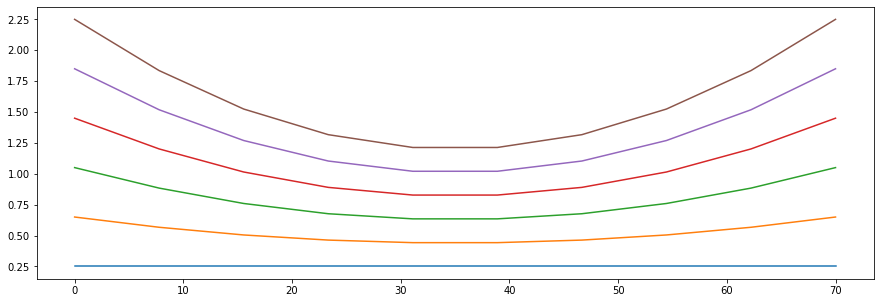

In [18]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
for i in cableprofile:
    x, y = zip(*i)
    plt.plot(x, y)

### Eccentricity of cables

In [19]:
def eccentricity(cable_positions, centroid):
    cable_areaxpos_sum = 0
    for i in cable_positions:
        cable_areaxpos_sum+=(i[1]-centroid)
    return cable_areaxpos_sum/len(cable_positions)

### Stress

In [20]:
list_of_sections = sections
prestressing_force_total = prestressing_force*cable_no
# prestressing_force_withloss = 0.75*prestressing_force

In [21]:
def tau(section, bm):
    tau_top = bm*section.ymin/section.I[0]
    tau_bot = -bm*section.ymax/section.I[0]
    return (tau_top, tau_bot)

presetressing stress

In [22]:
#due to eccentricity
bm_pre = [prestressing_force_total*eccentricity(i.cableprop, i.Centroid[1]) for i in list_of_sections] #bm due to full prestressing force

list_tau_pre = [tau(list_of_sections[index], bm_pre[index]) for index in range(len(list_of_sections))] #stress due to full prestressing force

#axial
list_tau_ax = [prestressing_force_total/sum(i.section_area) for i in list_of_sections]

list_tau_preTotal = [(list_tau_pre[index][0] + list_tau_ax[index], list_tau_pre[index][1] + list_tau_ax[index]) for index in range(len(list_of_sections))]

In [23]:
list_tau_preTotal

[(2716.7921705884755, 10316.840958644709),
 (1625.4514510584213, 11977.569874433264),
 (997.1037640562681, 12933.74712897819),
 (831.7491095820187, 13185.372722279484),
 (1129.3874876356685, 12732.446654337153),
 (1890.0188982172222, 11574.96892515119),
 (3113.643341326678, 9712.939534721596),
 (4800.260816964036, 7146.358483048374),
 (6949.871325129295, 3875.2257701315234)]

stress due to ded load

In [24]:
list_tau_DL = [tau(list_of_sections[index], bm_pdl[index]) for index in range(len(list_of_sections))]

In [25]:
list_tau_DL

[(0.0, -0.0),
 (5007.479323714603, -7620.0452885943505),
 (8584.250269225033, -13062.934780447456),
 (10730.312836531293, -16328.668475559325),
 (11445.667025633382, -17417.246373929946),
 (10730.312836531293, -16328.668475559325),
 (8584.250269225033, -13062.934780447456),
 (5007.479323714603, -7620.0452885943505),
 (0.0, -0.0)]

stress due to surfacing

In [26]:
list_tau_surf = [tau(list_of_sections[index], bm_surf[index]) for index in range(len(list_of_sections))]

In [27]:
list_tau_surf

[(0.0, -0.0),
 (200.4159654692539, -304.9795385475897),
 (343.570226518721, -522.8220660815823),
 (429.46278314840123, -653.5275826019779),
 (458.0936353582946, -697.0960881087764),
 (429.46278314840123, -653.5275826019779),
 (343.570226518721, -522.8220660815823),
 (200.4159654692539, -304.9795385475897),
 (0.0, -0.0)]

stress due to other load

In [28]:
list_tau_ODL = [tau(list_of_sections[index], bm_odl[index]) for index in range(len(list_of_sections))]

In [29]:
list_tau_ODL

[(0.0, -0.0),
 (303.66055374129377, -462.0902099205904),
 (520.5609492707893, -792.154645578155),
 (650.7011865884867, -990.1933069726938),
 (694.0812656943858, -1056.2061941042066),
 (650.7011865884867, -990.1933069726938),
 (520.5609492707893, -792.154645578155),
 (303.66055374129377, -462.0902099205904),
 (0.0, -0.0)]

stress due to live load

In [30]:
list_tau_LL = [tau(list_of_sections[index], bm_ll[index]) for index in range(len(list_of_sections))]

In [31]:
arr_stress_top = np.array([
    list(zip(*list_tau_DL))[0], 
    list(zip(*list_tau_ODL))[0], 
    list(zip(*list_tau_surf))[0], 
    list(zip(*list_tau_LL))[0], 
    list(zip(*list_tau_preTotal))[0]
])

arr_stress_bot = np.array([
    list(zip(*list_tau_DL))[1], 
    list(zip(*list_tau_ODL))[1], 
    list(zip(*list_tau_surf))[1], 
    list(zip(*list_tau_LL))[1], 
    list(zip(*list_tau_preTotal))[1]
])

**Case 1: Rare combination I**

RI = DL + PS@10%loss

In [32]:
psf_RI = np.array([1, 0, 0, 0, 0.9]) #partial safety factor [DL, ODL, surf, LL, Ps] irc:6-2007 table B3

tauTop_RI = psf_RI.dot(arr_stress_top) #resultant pressure top

tauBot_RI = psf_RI.dot(arr_stress_bot) #resultant pressure bottom

tauTop_RI, tauBot_RI

(array([ 2445.11295353,  6470.38562967,  9481.64365688, 11478.88703516,
        12462.11576451, 12431.32984493, 11386.52927642,  9327.71405898,
         6254.88419262]),
 array([ 9285.15686278,  3159.7675984 , -1422.56236437, -4461.83302551,
        -5958.04438503, -5911.19644292, -4321.2891992 , -1188.32265385,
         3487.70319312]))

Allowable stresses

In [33]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.48*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-3276, 16800)

check

In [34]:
if all(tauTop_RI>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_RI<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 2: Rare combination II**

RII = DL + ODL + 1.2*Surf + 0.75*LL + PS@25%loss

In [35]:
psf_RII = np.array([1, 1, 1.2, 0.75, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_RII = psf_RII.dot(arr_stress_top) #resultant pressure top

tauBot_RII = psf_RII.dot(arr_stress_bot) #resultant pressure bottom

tauTop_RII, tauBot_RII

(array([ 2037.59412794,  7192.81672702, 10991.41727197, 13433.39604729,
        14519.67745469, 14258.55180409, 12615.75250015,  9593.0290492 ,
         5212.40349385]),
 array([  7737.63071898,   -107.24035053,  -5887.69520906,  -9603.73428956,
        -11256.76428439, -10859.40082966,  -8359.49932495,  -3759.72205137,
          2906.4193276 ]))

Allowable stresses

In [36]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.36*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-3276, 12600)

check

In [37]:
if all(tauTop_RII>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_RII<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 2: Rare combination II**

RII = DL + ODL + 1.2*Surf + LL + PS@25%loss

In [38]:
psf_RII = np.array([1, 1, 1.2, 1, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_RII = psf_RII.dot(arr_stress_top) #resultant pressure top

tauBot_RII = psf_RII.dot(arr_stress_bot) #resultant pressure bottom

tauTop_RII, tauBot_RII

(array([ 2037.59412794,  7333.51309459, 11233.58192483, 13737.80099802,
        14847.40284976, 14573.44122661, 12870.22733476,  9740.09384935,
         5212.40349385]),
 array([  7737.63071898,   -321.34262106,  -6256.20509255, -10066.95727276,
        -11755.47475151, -11338.57837695,  -8746.74201518,  -3983.51537433,
          2906.4193276 ]))

Allowable stresses

In [39]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.46*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-3276, 16100)

check

In [40]:
if all(tauTop_RII>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_RII<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 3: Permanent combination**

RII = DL + ODL + 1.2*Surf + 0.75*LL + PS@25%loss

In [41]:
psf_P = np.array([1, 1, 1.2, 0.75, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_P = psf_P.dot(arr_stress_top) #resultant pressure top

tauBot_P = psf_P.dot(arr_stress_bot) #resultant pressure bottom

tauTop_P, tauBot_P

(array([ 2037.59412794,  7192.81672702, 10991.41727197, 13433.39604729,
        14519.67745469, 14258.55180409, 12615.75250015,  9593.0290492 ,
         5212.40349385]),
 array([  7737.63071898,   -107.24035053,  -5887.69520906,  -9603.73428956,
        -11256.76428439, -10859.40082966,  -8359.49932495,  -3759.72205137,
          2906.4193276 ]))

Allowable stresses

In [42]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.36*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-3276, 12600)

check

In [43]:
if all(tauTop_P>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_P<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


**Case 4: Quasi-Permanent**

QP = DL + ODL + PS@25%loss

In [44]:
psf_QP = np.array([1, 1, 0, 0, 0.75]) #partial safety factor [DL, ODL, surf, LL, PS] irc:6-2007 table B3

tauTop_QP = psf_QP.dot(arr_stress_top) #resultant pressure top

tauBot_QP = psf_QP.dot(arr_stress_bot) #resultant pressure bottom

tauTop_QP, tauBot_QP

(array([ 2037.59412794,  6530.22846575,  9852.63904154, 12004.82585531,
        12986.78890705, 12798.52819678, 11440.04372449,  8911.33549018,
         5212.40349385]),
 array([ 7737.63071898,   901.04190731, -4154.77907929, -7429.83224082,
        -8924.11757728, -8637.63508867, -6570.38477498, -2722.36663623,
         2906.4193276 ]))

Allowable stresses

In [45]:
tauTop_perm = -int(0.259*math.pow(fck, 2/3)*1000) #permissible stress on top (tensile) kN/m2

tauBot_perm = int(0.36*35*1000) #permissible stress on top (compression) kN/m2
tauTop_perm, tauBot_perm

(-3276, 12600)

check

In [46]:
if all(tauTop_QP>tauTop_perm) == True:
    print('top ok')
else:
    print('top not ok')
    
if all(tauBot_QP<tauBot_perm) == True:
    print('bottom ok')
else:
    print('bottom not ok')

top ok
bottom ok


In [47]:
tauTop_QP, tauBot_QP

(array([ 2037.59412794,  6530.22846575,  9852.63904154, 12004.82585531,
        12986.78890705, 12798.52819678, 11440.04372449,  8911.33549018,
         5212.40349385]),
 array([ 7737.63071898,   901.04190731, -4154.77907929, -7429.83224082,
        -8924.11757728, -8637.63508867, -6570.38477498, -2722.36663623,
         2906.4193276 ]))

### Ultimate strength Check

material property cable

In [114]:
nos = 19 # input number of strand
art = 98.7 # input area of one tendon mm

fpk = 1860 # breaking stress
es = 195000 # modulus of elasticity

#### calculation of effective depth and xulim

##### effective depth
eff depth = depth - $\frac{\displaystyle\sum_{i=1} ^{j} y*n}{\displaystyle\sum_{i=1} ^{j} n}$

where,<br>
n = no of cables in layer i <br>
y = depth from bottom <br>
j represents total number of layer <br><br><br>

##### xu lim
$x_{u,\ lim\ }=\ \frac{\epsilon_{cu2}}{\epsilon_{cu2}+\ \epsilon}$<br>
where,<br>
$\epsilon$ = design strain = fpd/Es

In [115]:
depth = sections[0].position[3][1] + sections[0].height[3] - sections[0].position[1][1] #input dept from slab top to bottom mm
n = cable_no #input number of cables
effd = [] #effective depth at different sections
xulim = [] #limiting depth
for i in sections:
    cpx, cpy = zip(*i.cableprop)
    arr_y = np.array(list(set(cpy)))
    arr_n = np.array([cpy.count(i) for i in set(cpy)])
    ed = depth - sum(arr_y*arr_n)/n

    xul = ecu2/(ecu2+e)*ed
    
    effd.append(ed)
    xulim.append(xul)

Adopted Stress Strain Curve for Ultimate Strength Check

In [116]:
ecu2 = 0.0035
ec2 = 0.0020

fp0 = fpk*0.87
fpd = fp0/1.15

e = fpd/es #design strain

strain-stress concrete

In [117]:
def stress(ec2, fck):
    """
    stress strain relationship. refer to IRC: 112-2020 Cl. 6.4.2.8
    :param ec2: strain
    :param fck: fck of concrete
    :return: stress for giver strain ec2 for concrete of grade fck
    """
    if ec2 < 0:
        stress = 0
    elif 0 <= ec2 <= 0.002:
        stress = 0.67*fck/1.5 * (1 - np.power((1 - ec2 / 0.002), 2))
    else:
        stress = 0.67*fck/1.5
    return stress

In [118]:
def interpolate_e(etop, ebot, depth, y):
    """
    interpolate strain at certain depth from bottom
    :param etop: strain at top
    :param ebot: strain at bottom
    :param y: distance at which e is required (from bottom)
    :param d: depth of section
    :return: strain
    """
    
    e = etop + (ebot-etop)/depth*(depth-y)
    return e

Neutral axis
NA=$\ \frac{depth}{\epsilon_{cu2}\ -\ \epsilon_{bot}}\times(0-\epsilon_{bot})$

In [119]:
etop = 0.0035
ebot = -0.02

def na(etop, ebot, depth):
    """
    interpolate neutral axis
    :param etop: strain at top
    :param ebot: strain at bottom
    :param depth: depth of section
    :return: depth of neutral axis from bottom
    """
    na = depth/(ecu2 - ebot)*-ebot
    return na

NA = na(etop, ebot, depth)

dividing section to number of stripes

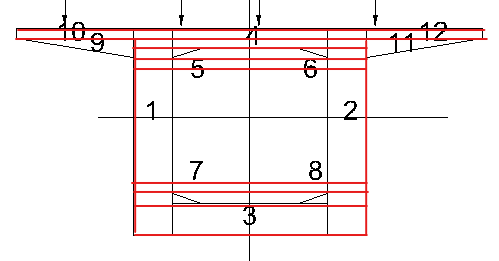

In [100]:
depth = sections[0].position[3][1] + sections[0].height[3] - sections[0].position[1][1] #input dept from slab top to bottom mm

i = 0
topslab1_b = sections[i].position[5][0]+sections[i].length[5] - (sections[i].position[4][0]) # total width upto cantiliver form top
topslab1_d = sections[i].height[4]
topslab1_pos = sections[i].position[4][1] + topslab1_d/2

topslab2_b = sections[i].length[0] + sections[i].length[1] + sections[i].length[2]
topslab2_d = sections[i].height[3] - sections[i].height[4]
topslab2_pos = topslab1_pos - (topslab1_d+topslab2_d)/2

stripes = [[topslab1_b, topslab1_d, topslab1_pos], [topslab2_b, topslab2_d, topslab2_pos]] #[[width, depth, pos]]

n = 10 #no of division
web_d = (depth - sections[i].height[3] - sections[i].height[2])/n #depth each stripes of web without top and bottom slab
web_b = sections[i].length[0]*2

for j in range(n):
    stripe_pos = sections[i].position[3][1] - web_d/2 - j*web_d
    stripes.append([web_b, web_d, stripe_pos])

botslab_b = topslab2_b
botslab_d = sections[i].height[2]
botslab_pos = sections[i].position[2][1] + botslab_d/2
stripes.append([botslab_b, botslab_d, botslab_pos])

distance to top of stripes from bottom

In [101]:
# depth = sections[0].position[3][1] + sections[0].height[3] - sections[0].position[1][1] #input dept from slab top to bottom mm

int_dep = depth
dist = [int_dep] # list of distance to top of stripes from bottom
for i in stripes:
    dep = round(int_dep-i[1], 5)
    dist.append(dep)
    int_dep = dep

In [102]:
strn = [interpolate_e(etop, ebot, depth, i) for i in dist]
strs = [stress(i, fck) for i in strn]

strain-stress steel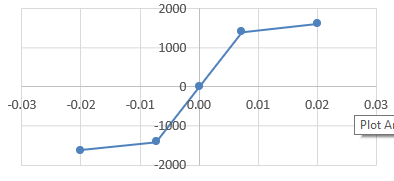

In [103]:
eud = 0.002 #sp105, pg 25
euk = eud/0.9

tau_0 = 0
tau_e = fpd
tau_eud = fp0
tau_euk = (tau_e-tau_eud)/(e-eud)*(euk-eud) + tau_eud


st_st = [-euk, -eud, -e, 0, e, eud, euk] #possible strain range
tau_st = [-tau_euk, -tau_eud, -tau_e, -tau_0, tau_e, tau_eud, tau_euk]

stress, area, force, moment of stripes in compression due of concrete

In [104]:
stripe_strs = [(strs[j]+strs[j+1])/2 for j in range(len(strs)-1)] #average stress of stripes
stripe_area = [j[0]*j[1] for j in stripes]
stripe_force = [stripe_strs[j]*stripe_area[j]*1000 for j in range(len(stripes))]
stripe_pos = [j[2] for j in stripes]
stripe_mom = [stripe_force[j]*(stripe_pos[j]-NA) for j in range(len(stripes))]

df_comp = pd.DataFrame([stripe_pos, stripe_strs, stripe_area, stripe_force, stripe_mom], index = ['Position', 'Stress', 'Area', 'Force', 'Moment'])
display(df_comp.T)

,Position,Stress,Area,Force,Moment
0,3.125,20.100000,1.380,27738.000000,11139.462766
1,2.975,18.857858,0.840,15840.600952,3985.427793
2,2.780,8.807858,0.288,2536.663184,143.564342
3,2.540,0.000000,0.288,0.000000,-0.000000
4,2.300,0.000000,0.288,0.000000,-0.000000
5,2.060,0.000000,0.288,0.000000,-0.000000
6,1.820,0.000000,0.288,0.000000,-0.000000
7,1.580,0.000000,0.288,0.000000,-0.000000
8,1.340,0.000000,0.288,0.000000,-0.000000
9,1.100,0.000000,0.288,0.000000,-0.000000


Cable layer

In [105]:

cpx, cpy = zip(*sections[0].cableprop)

cab_y = sorted(list(set(cpy)))
cab_layer = [[y, cpy.count(y)] for y in cab_y]  #[[y of cable from bottom, no of cables]]


In [110]:
cab_pos = cab_y
cab_strn = [interpolate_e(etop, ebot, depth, j) for j in cab_pos]
cab_strs = [np.interp(x, st_st, tau_st) for x in cab_strn]
cab_area = [nos*art * n[1] for n in cab_layer]
cab_force = [cab_strs[j]*cab_area[j]/1000 for j in range(len(cab_layer))]
cab_mom = [cab_force[j]*(cab_pos[j]-NA) for j in range(len(cab_layer))]

df_tens = pd.DataFrame([cab_pos, cab_strs, cab_area, cab_force, cab_mom], index = ['Position', 'Stress', 'Area', 'Force', 'Moment'])
df_tens.T

,Position,Stress,Area,Force,Moment
0,0.25,-1609.207694,13127.1,-21124.230324,52248.761173
1,0.65,-1609.207694,3750.6,-6035.494378,12514.019727
2,1.05,-1609.207694,3750.6,-6035.494378,10099.821975
3,1.45,-1609.207694,3750.6,-6035.494378,7685.624224
4,1.85,-1609.207694,3750.6,-6035.494378,5271.426473
5,2.25,-1609.207694,3750.6,-6035.494378,2857.228722


In [121]:
i = 0 #for section[i]

### cable layer
cpx, cpy = zip(*sections[i].cableprop)

cab_y = sorted(list(set(cpy)))
cab_layer = [[y, cpy.count(y)] for y in cab_y]  #[[y of cable from bottom, no of cables]]

### initial value of sum of comp moment and tensile moment
sum_mc = 0
sum_mt = 10

### initial value of top and bottom strain
etop = 0.0035
ebot = e

while abs(sum_mc - sum_mt) > 5 :
    ### neutral axis
    NA = na(etop, ebot, depth)
    
    ### dividing section to number of stripes
    topslab1_b = sections[i].position[5][0]+sections[i].length[5] - (sections[i].position[4][0]) # total width upto cantiliver form top
    topslab1_d = sections[i].height[4]
    topslab1_pos = sections[i].position[4][1] + topslab1_d/2

    topslab2_b = sections[i].length[0] + sections[i].length[1] + sections[i].length[2]
    topslab2_d = sections[i].height[3] - sections[i].height[4]
    topslab2_pos = topslab1_pos - (topslab1_d+topslab2_d)/2

    stripes = [[topslab1_b, topslab1_d, topslab1_pos], [topslab2_b, topslab2_d, topslab2_pos]] #[[width, depth, pos]]

    n = 10 #no of division
    web_d = (depth - sections[i].height[3] - sections[i].height[2])/n #depth each stripes of web without top and bottom slab
    web_b = sections[i].length[0]*2

    for j in range(n):
        stripe_pos = sections[i].position[3][1] - web_d/2 - j*web_d
        stripes.append([web_b, web_d, stripe_pos])

    botslab_b = topslab2_b
    botslab_d = sections[i].height[2]
    botslab_pos = sections[i].position[2][1] + botslab_d/2
    stripes.append([botslab_b, botslab_d, botslab_pos])
    
    ### distance to top of stripes from bottom
    int_dep = depth
    dist = [int_dep] # list of distance to top of stripes from bottom
    for j in stripes:
        dep = round(int_dep-j[1], 5)
        dist.append(dep)
        int_dep = dep
        
    strn = [interpolate_e(etop, ebot, depth, i) for i in dist]
    strs = [stress(i, fck) for i in strn]
    
    ### stress, area, force, moment of stripes in compression due of concrete
    stripe_strs = [(strs[j]+strs[j+1])/2 for j in range(len(strs)-1)] #average stress of stripes
    stripe_area = [j[0]*j[1] for j in stripes]
    stripe_force = [stripe_strs[j]*stripe_area[j]*1000 for j in range(len(stripes))]
    stripe_pos = [j[2] for j in stripes]
    stripe_mom = [stripe_force[j]*(stripe_pos[j]-NA) for j in range(len(stripes))]

    df_comp = pd.DataFrame([stripe_pos, stripe_strs, stripe_area, stripe_force, stripe_mom], index = ['Position', 'Stress', 'Area', 'Force', 'Moment'])
#     display(df_comp.T)
    
    ### stress, area, force, moment of stripes in compression due of concrete
    cab_pos = cab_y
    cab_strn = [interpolate_e(etop, ebot, depth, j) for j in cab_pos]
    cab_strs = [np.interp(x, st_st, tau_st) for x in cab_strn]
    cab_area = [nos*art * n[1] for n in cab_layer]
    cab_force = [cab_strs[j]*cab_area[j]/1000 for j in range(len(cab_layer))]
    cab_mom = [cab_force[j]*(cab_pos[j]-NA) for j in range(len(cab_layer))]

    df_tens = pd.DataFrame([cab_pos, cab_strs, cab_area, cab_force, cab_mom], index = ['Position', 'Stress', 'Area', 'Force', 'Moment'])
    
    
    sum_mc = df_comp.T.sum()[-1]
    sum_mt = df_tens.T.sum()[-1]
    
    ebot = ebot - 0.00001

KeyboardInterrupt: 

In [113]:
df_tens.T.sum()[-1]

90676.88229328545